# Gender Classification

## Introduction
The aim of the paper is to choose the best gender classification model between Logistic Regresson, SVM, Random Forest and Adaptive Boost algorithms. I will also do an experiment by combining algorithms. The particular thing about this is that we have relatively small data about famous public figures. At the end of the paper you will also see how well the chosen model works for common people. I suspect that the best model will be SVM, but let's see what happens.

## Table of content
- [Introduction](#Introduction)
- [Data processing](#Data-processing)
    - [How to get the image dataset?](#How-to-get-the-image-dataset?)
    - [Image data description](#Image-data-description)
    - [Reducing the examples and balancing the data](#Reducing-the-examples-and-balancing-the-data)
    - [Separating the data](#Separating-the-data)
- [Dimensionality reduction](#Dimensionality-reduction)
    - [Image transformations](#Image-transformations)
    - [Feature-extraction](#Feature-extraction)
        - [Data normalization](#Data-normalization)
        - [Choice of the best features](#Choice-of-the-best-features)
        - [Eigenfaces](#Eigenfaces)
- [Model selection](#Model-selection)
    - [Preparation](#Preparation)
        - [Import the dataset](#Import-the-dataset)
        - [Define util functions](#Define-util-functions)
    - [Logistic Regression model](#Logistic-Regression-model)
        - [Basic Logistic Regression](#Basic-Logistic-Regression)
        - [Tune the Logistic Regression params](#Tune-the-Logistic-Regression-params)
        - [Analyse the Logistic Regression results](#Analyse-the-Logistic-Regression-results)
    - [Train SVM model](#Train-SVM-model)
        - [Basic Linear SVM model](#Basic-Linear-SVM-model)
        - [Tune the Linear SVM model](#Tune-the-Linear-SVM-model)
        - [Gaussian SVM model](#Gaussian-SVM-model)
        - [Analyse the SVM results](#Analyse-the-SVM-results)
    - [Random Forest clasifier](#Random-Forest-Clasifier)
        - [Basic Random Forest](#Basic-Random-Forest)
        - [Tune Random Forest parameters](#Tune-Random-Forest-parameters)
        - [Analyse the Random Forest results](#Analyse-the-Random-Forest-results)
    - [Adaptive Boost](#Adaptive-Boost)
        - [Basic AdaBoost with Decision Tree](#Basic-AdaBoost-with-Decision-Tree)
        - [Tune the AdaBoost parameters](#Tune-the-AdaBoost-parameters)
        - [Analyse the Ada Boost results](#Analyse-the-Ada-Boost-results)
    - [Experimental: attempt to combine models](#Experimental:-attempt-to-combine-models)
    - [Best model selection](#Best-model-selection)
- [Demo](#Demo)
    - [Define helpers](#Define-helpers)
    - [Gender recognition from the camera](#Gender-recognition-from-the-camera)
    - [Gender recognition from an image](#Gender-recognition-from-an-image)

I recommend you to install the `opencv` through `pip` because there is well known issues with the `conda` distribution - especially for Linux. The `opencv` library is used for the feature extraction and the [demo](#Demo) because it is easy work with camera and haar faces.

In [1]:
#run: `!conda remove --yes opencv` to remove conda opencv
!pip install opencv-python

In [2]:
%matplotlib inline

import os
import urllib
import tarfile
import re
from shutil import copyfile
import random
import time
import itertools
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import urllib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, SelectPercentile
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# Constants
NUMBER_OF_SAMPLES = 2900
RESIZE_SHAPE = (40, 40)
FEMALE_CLASS = 0
MALE_CLASS = 1

## Data processing
### How to get the image dataset?
If you want to download and extract the image dataset you can run the cell bellow. It will automate the downloading and extracting of the image data. Note that this is not very fast process. Alternatively you can download the image data from [here](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) and extract the `lfw-funneled.tar` file to `./faces_data/original_data/lfw-funneled` folder. On Windows for example you can use `7zip` extractor. Otherwise you can skip this part and download the generated `.csv` [later](#Feature-extraction).

In [3]:
# Time: ~5 minutes, size ~230Mb
# Downloads the  data
print("Downloading image data...")
response = urllib.request.urlretrieve("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz")
tar_url = response[0]
print("Image data downalod location: '{}'".format(tar_url))

Image data downalod location: '('/tmp/tmp8hhxx3b1', <http.client.HTTPMessage object at 0x7f7942c82278>)'


In [5]:
# Time: typically this is extremely fast process but can be very slow on Windows
# Extracts the downloaded data to './faces_data/original_data/lfw-funneled' directory
def extract(tar_url, extract_path="."):
    print("Source directory: '{}'".format(tar_url))
    print("Extracting to: '{}'".format(extract_path))
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])         
            
extract(tar_url, "./faces_data/original_data")
print('Done.')

Source directory: '/tmp/tmp8hhxx3b1'
Extracting to: './faces_data/original_data'
Done.


In [8]:
# This operation is not mandatory
# Removes the downlaoded *.tar file from the temporary folder
try:
    print("Removing '{}' ...".format(tar_url))
    os.remove(tar_url)
except Exception as ex:
    print(ex)
print('Done.')  

Removing '/tmp/tmp8hhxx3b1' ...
[Errno 2] No such file or directory: '/tmp/tmp8hhxx3b1'
Done.


## Image data description
We have dataset with `~5700` persons. Each person is assosiated with a folder with several pictures. All pictures are  `~13200`. The folders are not labeled but we have files with the female names and male names, so we can label each image easily. Each picture has dimensions `250x250px`. 
`./faces_data/original_data/female_names.txt`  
`./faces_data/original_data/male_names.txt`

Let's make some calculations and data visualization by labels and plot them:

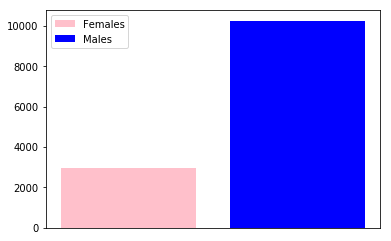

Females: 2966
Males: 10268


In [4]:
female_names_data = pd.read_csv('./faces_data/original_data/female_names.txt', header=None, sep='\n')
male_names_data = pd.read_csv('./faces_data/original_data/male_names.txt', header=None, sep='\n')

female_count = len(female_names_data)
male_count = len(male_names_data)

# plot diagram
fig, ax = plt.subplots()
colors = ['pink', 'blue']
rectangles = ax.bar((1, 2), (female_count, male_count), color=colors, width=0.8)
ax.xaxis.set_visible(False)
ax.legend((rectangles[0], rectangles[1]), ('Females', 'Males'))
plt.show()

print("Females: {} (label '0')".format(female_count))
print("Males: {} (label '1')".format(male_count))

From the graph we can see that we have highly unbalanced data. Furthermore we have a relatively large number of examples and a huge number of features `250*250=62500` and each feature has 3 components because the picture is colorful. With the components the features are `187500`! For this reason, I will make some suggestions and simplifications so that I can train my machine learning model on my processor for some tolerable period of time:
- I can get rid of the unbalanced data and the large number of examples by making the women/men ratio ~50/50
- I can reduce the huge number of features by making grayscale image and apply some image transformations. 
- In addition later I can use a feature extraction algorithm to reduce the number of features.
- I can perform data normalization because some algorithms work better with normalized data

So there is something to be done. Let's get to work!

### Reducing the examples and balancing the data
We have more men than women, so we can take all women and we can randomly get the same number of men:

In [6]:
female_names = female_names_data.get_values()[0:, 0]
male_names = male_names_data.get_values()[0:, 0]

female_names = random.sample(set(female_names), NUMBER_OF_SAMPLES)
male_names = random.sample(set(male_names), NUMBER_OF_SAMPLES)

print("Females: {}".format(len(female_names)))
print("Males: {}".format(len(male_names)))

Females: 2900
Males: 2900


In [16]:
# test randomization
female_names1 = random.sample(set(female_names), NUMBER_OF_SAMPLES)
female_names2 = random.sample(set(female_names), NUMBER_OF_SAMPLES)

print(len(set(female_names1) & set(female_names2)) == 2900)

True


### Separating the data
Let's create two folders where we will hold the representatives of the relevant classes:

In [84]:
source_image_dir = "./faces_data/original_data/lfw_funneled/"
directory_female = "./faces_data/new_data/female/"
directory_male = "./faces_data/new_data/male/"
if not os.path.exists(directory_female):
    os.makedirs(directory_female)
if not os.path.exists(directory_male):
    os.makedirs(directory_male)

In [85]:
def separate_data(face_names_data, source, destination):
    """Searches for a specific image by name and copy the image to a specific destination"""
    for image_name in face_names_data:
        name = re.match("([A-Za-z_-]+)_(\d+.jpg)", image_name)
        if name is None:
            print("Name: {}".format(image_name))
        name = name.group(1)    
        path = source_image_dir + name + "/" + image_name
        copyfile(path, destination + image_name)

In [86]:
# separates the data
separate_data(female_names, source_image_dir, directory_female)
separate_data(male_names, source_image_dir, directory_male)

In [87]:
# test print for the selected names
female_image_names = os.listdir("./faces_data/new_data/female")
male_image_names = os.listdir("./faces_data/new_data/male")
print(len(female_image_names))
print(len(male_image_names))

2900
2900


## Dimensionality reduction

### Image transformations

Now I'll extract the features from the image following these actions:
1. Get the original image
2. Convet the image to grayscale
3. Define the region of interests. Use haar faces to detect a face (if exists) on the image. If there is more than one face, I'll get the square with the larger area.
4. Crop the square from the gray image
5. Apply gaussian kernel over the cropped image to reduce the noise.
6. Resize the image to 40x40px  

| | | |
|: - :|: - :|: - :|
|![original image](./markdown_res/Amelia_Vega_0001.jpg) | ![gray image](./markdown_res/Amelia_Vega_0001_gray.bmp) | ![face](./markdown_res/Amelia_Vega_0001_face.bmp) |
| ![cropped face](./markdown_res/Amelia_Vega_0001_cropped.bmp) | ![resized face](./markdown_res/Amelia_Vega_0001_kernel.bmp) | ![resized face](./markdown_res/Amelia_Vega_0001_resized.bmp) |

In [114]:
gender_faces_data = None
gender_faces_data = np.empty(shape=(0,RESIZE_SHAPE[0]*RESIZE_SHAPE[1]+1)) #64*64+1
face_cascade = cv2.CascadeClassifier('./faces_data/face.xml')

def extract_features(image_path, label):
    """ Extracts features from a image
    :param image_path: the path to the image
    :param label: the label of the image
    :return: extracted features from the image with the corresponding label as a row matrix
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    row = None
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces is not ():
        face = sorted(faces, key=lambda x: (x[2] * x[3]), reverse=True)[0]
        x, y, width, height = face
        face_gray = gray[y: y + height, x: x + width]
        
        # apply Gaussian kernel
        kernel = np.ones((3,3),np.float32)/9
        face_gray = cv2.filter2D(face_gray,-1,kernel)
        
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        row = np.append(resized.ravel(), label)

    return row

def append_data(prefix_path, label, gender_faces_data):
    """ Appends data to a numpy array"""
    image_names = os.listdir(prefix_path)
    for image_path in image_names:
        # print(image_path)
        curr_row = extract_features(prefix_path + image_path, label)
        if curr_row is not None:
            gender_faces_data = np.append(gender_faces_data, [curr_row], axis=0)
        
    return gender_faces_data  

Now I will append the data and add labels: `female -> 0` and `male -> 1`

In [115]:
# Time: 1.5-2 min
# Append the female faces
gender_faces_data = append_data('./faces_data/new_data/female/', FEMALE_CLASS, gender_faces_data)
female_data = gender_faces_data

# Append the male faces
gender_faces_data = append_data('./faces_data/new_data/male/', MALE_CLASS, gender_faces_data)

print("Females count: {}".format(female_data.shape[0]))
print("Males count: {}".format(gender_faces_data.shape[0] - female_data.shape[0]))
print("Gender data shape: {}".format(gender_faces_data.shape))

In [90]:
# Suffle the data
np.random.shuffle(gender_faces_data)
gender_faces_data

array([[ 40.,  32.,  26., ...,  87.,  86.,   1.],
       [ 59.,  56.,  49., ...,  72.,  84.,   0.],
       [ 29.,   6.,  13., ..., 105., 200.,   0.],
       ...,
       [ 38.,  56.,  68., ...,  29.,  34.,   1.],
       [ 12.,  15.,  17., ...,  12.,  11.,   1.],
       [188., 188., 188., ..., 108., 173.,   1.]])

The data for the model is generated. The only thing left is to keep it in a file:

In [91]:
np.savetxt("./faces_data/genders_data_40x40_large_2.csv", gender_faces_data.astype(np.int), delimiter=",")

### Feature extraction
I will use **Principal Component Analysis(PCA)** for the feature extraction. The downside of using PCA is that the algorithm does not care about the labels. It simply applies the feature dimensionality reduction. However, as we shall see below, it produces good results.

The cell below will download the `*.csv` file that I generated earlier if it does not already exist locally.

In [3]:
# Time 1-2 min, size ~200Mb
# downloads the dataset if does not exists
dataset_file = "./faces_data/genders_data_40x40_large_2.csv"
if not os.path.exists(dataset_file):
    # Downloads the  data
    print("Downloading a dataset...")
    response = urllib.request.urlretrieve(
        "https://www.dropbox.com/s/5rp97ixw8a85v1t/genders_data_40x40_large_2.csv?dl=1", dataset_file)
    print("Dataset downalod location: '{}'".format(response[0]))

gender_faces_data = pd.read_csv(dataset_file, sep=',', header=None)
gender_faces_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,40.0,32.0,26.0,23.0,21.0,22.0,29.0,67.0,84.0,67.0,...,106.0,93.0,93.0,94.0,92.0,92.0,90.0,87.0,86.0,1.0
1,59.0,56.0,49.0,40.0,40.0,46.0,61.0,80.0,109.0,119.0,...,196.0,173.0,178.0,200.0,192.0,162.0,60.0,72.0,84.0,0.0
2,29.0,6.0,13.0,26.0,9.0,4.0,5.0,30.0,62.0,106.0,...,87.0,17.0,22.0,57.0,68.0,65.0,55.0,105.0,200.0,0.0
3,79.0,83.0,86.0,86.0,87.0,86.0,81.0,64.0,29.0,70.0,...,67.0,93.0,100.0,108.0,119.0,133.0,134.0,131.0,161.0,1.0
4,29.0,28.0,32.0,53.0,75.0,66.0,60.0,70.0,71.0,70.0,...,143.0,82.0,12.0,24.0,34.0,43.0,45.0,40.0,34.0,1.0


#### Data normalization
It is better to normalize the data before trying diffrent feature selection algorihms. For `PCA` it is even mandatory.

In [13]:
# get features
features = gender_faces_data.as_matrix()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

# get labels
labels = gender_faces_data.as_matrix()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel() # labels = gender_faces_data.as_matrix()[:, 50*50:].ravel()
print(labels.shape)
print(labels)

(5487, 1600)
(5487,)
[1. 0. 0. ... 1. 1. 1.]


In [14]:
# calculates the final counts
unique, count = np.unique(labels, return_counts=True)
print("Females count: {}".format(count[0]))
print("Males count: {}".format(count[1]))
# out = np.histogram(labels, bins=labels)
print(dict(zip(unique, count)))

Females count: 2737
Males count: 2750
{0.0: 2737, 1.0: 2750}


The balance between women and men is almost perfect. The number is below 2900 because not all faces are detected from the haar cascades.

#### Choice of the best features
It is difficult to find the best `PCA` parameters but I can make very rough approximations with something like grid search.

In [97]:
print("Features shape: {}".format(features.shape))
features_counts = [80, 140, 200, 260, 320, 380, 440, 1000]
test_scores = []
train_scores = []
for f_count in features_counts:
    print("Reducing features to {} ...".format(f_count))
    pca = PCA(n_components=f_count)

    pca.fit(features)
    reduced_features = pca.transform(features)
    
    features_train, features_test, labels_train, labels_test = train_test_split(
        reduced_features, labels, train_size=0.7, test_size=0.3, random_state=0)
    
    logistic_regression = LogisticRegression(C=0.001)
    logistic_regression.fit(features_train, labels_train)
    
    test_score = logistic_regression.score(features_test, labels_test)
    train_score = logistic_regression.score(features_train, labels_train)
    
    print("    train_score: {}".format(train_score))
    print("    test_score: {}".format(test_score))
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
print("Finished.")

Features shape: (5487, 1600)
Reducing features to 80 ...
    train_score: 0.8390625
    test_score: 0.8318154219793564
Reducing features to 140 ...
    train_score: 0.8572916666666667
    test_score: 0.840922890103218
Reducing features to 200 ...
    train_score: 0.8559895833333333
    test_score: 0.8421372191863995
Reducing features to 260 ...
    train_score: 0.8580729166666666
    test_score: 0.8397085610200364
Reducing features to 320 ...
    train_score: 0.8598958333333333
    test_score: 0.8397085610200364
Reducing features to 380 ...
    train_score: 0.8598958333333333
    test_score: 0.8427443837279903
Reducing features to 440 ...
    train_score: 0.8614583333333333
    test_score: 0.8421372191863995
Reducing features to 1000 ...
    train_score: 0.8630208333333333
    test_score: 0.8421372191863995
Finished.


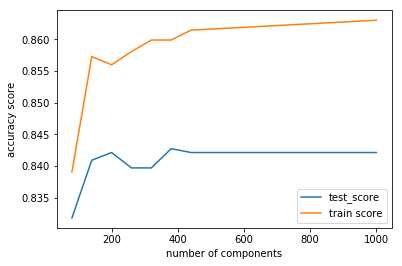

In [98]:
plt.plot(features_counts, test_scores)
plt.plot(features_counts, train_scores)
plt.legend(["test_score", "train score"])
plt.xlabel("number of components")
plt.ylabel("accuracy score")
plt.show()

I know that this type of calculation can be misleading because I have not applied cross-validation and grid rearch for the best parameters. However, they may be a very general reference and correspond to what I have identified with many attempts. So `n_components=200` even `n_components=150` is a good choice.

#### Eigenfaces
Let's see what the computer actually sees:

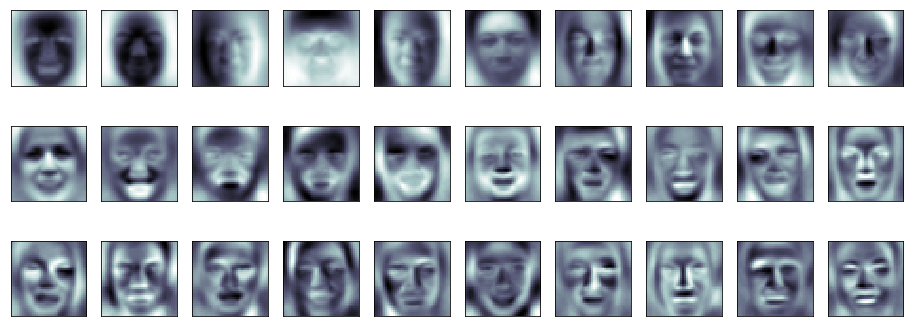

In [16]:
eigenface_scaler = StandardScaler()
eigenface_features = eigenface_scaler.fit_transform(features)

fig = plt.figure(figsize=(16, 6))
pca_eigenface = PCA(n_components=200, whiten=True)
pca_eigenface.fit(eigenface_features)

for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    plt.imshow(pca_eigenface.components_[i].reshape((40,40)), cmap=plt.cm.bone)

## Model selection
As we have seen, the data is well balanced and therefore I will choose **Accuracy Score** for metric. Also I will use **Learning Curve**, **ROC curve** and **Confusion Matrix** to analyze the results.

### Preparation

#### Import the dataset

In [3]:
gender_faces_data = pd.read_csv('./faces_data/genders_data_40x40_large_2.csv', sep=',', header=None)

print(gender_faces_data.shape)
gender_faces_data.head()

(5487, 1601)


,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,40.0,32.0,26.0,23.0,21.0,22.0,29.0,67.0,84.0,67.0,...,106.0,93.0,93.0,94.0,92.0,92.0,90.0,87.0,86.0,1.0
1,59.0,56.0,49.0,40.0,40.0,46.0,61.0,80.0,109.0,119.0,...,196.0,173.0,178.0,200.0,192.0,162.0,60.0,72.0,84.0,0.0
2,29.0,6.0,13.0,26.0,9.0,4.0,5.0,30.0,62.0,106.0,...,87.0,17.0,22.0,57.0,68.0,65.0,55.0,105.0,200.0,0.0
3,79.0,83.0,86.0,86.0,87.0,86.0,81.0,64.0,29.0,70.0,...,67.0,93.0,100.0,108.0,119.0,133.0,134.0,131.0,161.0,1.0
4,29.0,28.0,32.0,53.0,75.0,66.0,60.0,70.0,71.0,70.0,...,143.0,82.0,12.0,24.0,34.0,43.0,45.0,40.0,34.0,1.0


In [4]:
features = gender_faces_data.as_matrix()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

(5487, 1600)


In [5]:
labels = gender_faces_data.as_matrix()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel()
print(labels.shape)
print(labels)

(5487,)
[1. 0. 0. ... 1. 1. 1.]


#### Define util functions

In [6]:
def plot_roc_curve(estimator, features_test, labels_test, title):
    """ Plots ROC curve"""
    logit_roc_auc = roc_auc_score(labels_test, estimator.predict(features_test))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        labels_test, estimator.predict_proba(features_test)[:,1])
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='{} (area = {:0.2f})'.format(title, logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    return plt

In [7]:
def print_grid_search_results(grid_search_pipeline, splits):
    """ Prints reformated version of the cv_results_
    :param grid_search_pipeline: grid_search estimator
    :param splits: the number of the kFold splits
    :return: table with parameters
    """
    results = pd.DataFrame(grid_search_pipeline.cv_results_)
    results = results.drop(['mean_fit_time', 'mean_score_time', 'std_fit_time', 'std_score_time', 'params'], axis=1)
    columns = columns={"param_pca__n_components": "param_pca", "param_classifier__C": "param_C", 
                       "mean_test_score": "mean_test","mean_train_score": "mean_train", "rank_test_score": 
                       "rank_test", "param_clf__n_estimators": "n_estimators"}
    for i in range(0, splits):
        columns["split" + str(i) + "_train_score"]="split" + str(i) + "_train"
        columns["split" + str(i) + "_test_score"]="split" + str(i) + "_test"
    results = results.rename(columns=columns)
    results.sort_values(by='rank_test', inplace=True)
    return results.head(len(grid_search_pipeline.cv_results_['params']))

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    For more info see the origanl documtation here: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [9]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Logistic Regression model

#### Basic Logistic Regression
I will create a `pipeline` for the models because it is convenient to use not only during the training but also during the use of the model. I can simply call `pipeline_model.predict(...)` and it will handle the `PCA` and `Scaler` transformations for the input data. It is therefore a prerequisite for fewer mistakes. On the other hand, invoking `PCA` and `Scaler` every time when creating each model will reduce performance. But for the purpose of this study, this is not so important.

In [10]:
# split the data to train and test set
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=42)

In [11]:
# creates a pipeline for Logistic Regression
logistic_regression_pipe = None
logistic_regression = LogisticRegression(random_state=42)
logistic_regression_pipe = Pipeline(steps=[('scaler_before', StandardScaler()), 
                          ('pca', PCA(n_components=150)),
                          ('scaler_after', StandardScaler()),
                          ('classifier', logistic_regression)])

In [12]:
# fit the basic Logistic Regression model
logistic_regression_pipe.fit(features_train, labels_train)

Pipeline(memory=None,
     steps=[('scaler_before', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('scaler_after', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifie...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [13]:
print("Basic logistic regression test accuracy score: {}".format(
    logistic_regression_pipe.score(features_test, labels_test)))
print("Basic logistic regression train accuracy score: {}".format(
    logistic_regression_pipe.score(features_train, labels_train)))
print("Basic logistic regression F1 score: {}".format(
    f1_score(labels_test, logistic_regression_pipe.predict(features_test))))
# Basic logistic regression test accuracy score: 0.8469945355191257
# Basic logistic regression train accuracy score: 0.8669270833333333
# Basic logistic regression F1 score: 0.8481927710843373

Basic logistic regression test accuracy score: 0.8415300546448088
Basic logistic regression train accuracy score: 0.86640625
Basic logistic regression F1 score: 0.8430547203848466


The result seems fairly good but we need to check whether this is due to the separation of data (see the difference between the train score and the test score). Moreover we also need to look for better parameters. So we have to make `kFold cross-validation` and `grid search`.

#### Tune the Logistic Regression params

In [14]:
# Time: ~1 min
# split the data to train and test set
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

params = dict(classifier__C=[0.0001, 0.001, 0.01, 1],
              #classifier__penalty=['l1', 'l2'],
              pca__n_components=[150, 200])

# init kFold validation
kfold = StratifiedKFold(n_splits=8)

# Grid search for the best Logistic Regression parameters
grid_search_logistic_regresion = GridSearchCV(
    logistic_regression_pipe, param_grid=params, cv=kfold, return_train_score=True, n_jobs=6)

grid_search_logistic_regresion.fit(features_train, labels_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler_before', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('scaler_after', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifie...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'classifier__C': [0.0001, 0.001, 0.01, 1], 'pca__n_components': [150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
grid_search_logistic_regresion.best_params_
# {'classifier__C': 0.01, 'pca__n_components': 150}

{'classifier__C': 0.0001, 'pca__n_components': 150}

In [16]:
print("Logistic Regression Grid Search best score: {}".format(grid_search_logistic_regresion.best_score_))
# Logistic Regression Grid Search best score: 0.8486979166666667

Logistic Regression Grid Search best score: 0.846875


In [17]:
print_grid_search_results(grid_search_logistic_regresion, splits=8)
# grid_search_logistic_regresion.param_grid
# grid_search_logistic_regresion.cv_results_

,mean_test,mean_train,param_C,param_pca,rank_test,split0_test,split0_train,split1_test,split1_train,split2_test,...,split4_test,split4_train,split5_test,split5_train,split6_test,split6_train,split7_test,split7_train,std_test_score,std_train_score
0,0.846875,0.866444,0.0001,150,1,0.839917,0.867818,0.835417,0.860714,0.841667,...,0.858333,0.864881,0.835417,0.869048,0.862500,0.866369,0.847599,0.866409,0.009794,0.002984
6,0.845833,0.868527,1,150,2,0.850312,0.869306,0.820833,0.862798,0.837500,...,0.856250,0.867560,0.831250,0.867857,0.862500,0.869345,0.855950,0.868789,0.013485,0.002697
1,0.845052,0.870238,0.0001,200,3,0.846154,0.867222,0.850000,0.872917,0.818750,...,0.850000,0.875000,0.829167,0.868750,0.852083,0.870238,0.851775,0.868789,0.013197,0.002673
4,0.844531,0.866592,0.01,150,4,0.848233,0.862161,0.822917,0.862798,0.831250,...,0.860417,0.867857,0.822917,0.869643,0.866667,0.863095,0.853862,0.867896,0.015747,0.003200
2,0.843229,0.865141,0.001,150,5,0.846154,0.863650,0.837500,0.860119,0.820833,...,0.852083,0.865179,0.820833,0.869345,0.862500,0.863095,0.845511,0.864624,0.014979,0.003377
3,0.842448,0.869866,0.001,200,6,0.844075,0.867818,0.845833,0.869940,0.827083,...,0.845833,0.871131,0.831250,0.870238,0.845833,0.869643,0.839248,0.870277,0.009563,0.001858
7,0.841406,0.873698,1,200,7,0.864865,0.870497,0.835417,0.872024,0.827083,...,0.847917,0.878869,0.820833,0.877083,0.847917,0.872024,0.837161,0.876227,0.013192,0.003007
5,0.839844,0.872470,0.01,200,8,0.852391,0.871093,0.835417,0.870238,0.818750,...,0.837500,0.876190,0.818750,0.875298,0.850000,0.872619,0.845511,0.873550,0.014279,0.003185


#### Analyse the Logistic Regression results
Let's plot some graphs. This would help us estimate what our algorithm suffers from in a more intuitive way.
##### Learning curve
The `Learning curve` would help us figure out if our algorithm suffers from a **high bias** or **high variance**

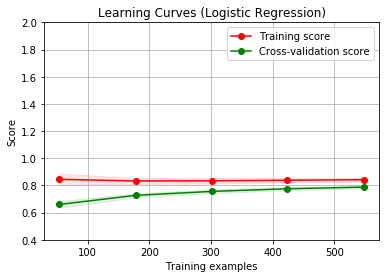

In [18]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.9, random_state=0)
scaled_features = StandardScaler().fit_transform(features)
pca_features = PCA(n_components=150).fit_transform(scaled_features)
linear_regression_estimator = LogisticRegression(C=0.001)

plot_learning_curve(linear_regression_estimator, title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)
plt.show()

It can be seen from the figure above that with appropriate regularization or increasing in the number of samples, we can reduce the **variance** between test data and train data significantly but we can not achieve a score greater than `0.85`. This means that in order to achieve better results we may change the bias because we have **high bias** problem - the curves are close to each other and both of them have lower than desired score.

##### Confusion matrix

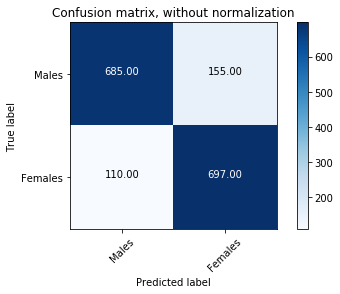

In [19]:
cnf_matrix = confusion_matrix(labels_test, grid_search_logistic_regresion.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), 
                      title='Confusion matrix, without normalization')
plt.show()

The matrix shows that our classifier tends to classify some men as women more than vice versa. Maybe the content of more images with men on the original set is not accidental. It is possible to deal with this problem if we take more males's samples from the original data.

##### ROC Curve

The "elbow" on the curve is not perfect but I will try to fix it by changing the bias.

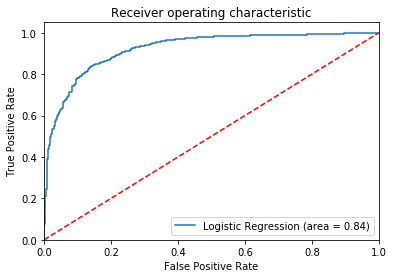

In [20]:
estimator = grid_search_logistic_regresion.best_estimator_
roc = plot_roc_curve(estimator, features_test, labels_test, title="Logistic Regression")
roc.show()

### Train SVM model

#### Basic Linear SVM model

In [21]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

In [22]:
linear_svm = LinearSVC(random_state=42)
linear_svm_pipeline = Pipeline(steps=[('scl', StandardScaler()), 
                               ('pca', PCA(n_components=200, random_state=42)),
                               ('scl_2', StandardScaler()),
                               ('clf', linear_svm)])

linear_svm_pipeline.fit(features_train, labels_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=200, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('scl_2', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))])

In [23]:
print("Train score: {}".format(linear_svm_pipeline.score(features_train, labels_train)))
print("Test score: {}".format(linear_svm_pipeline.score(features_test, labels_test)))
print("Diff score: {}".format(
    linear_svm_pipeline.score(features_train, labels_train) - linear_svm_pipeline.score(features_test, labels_test)))
# Train score: 0.8671875
# Test score: 0.8457802064359441
# Diff score: 0.021407293564055907

Train score: 0.8671875
Test score: 0.8457802064359441
Diff score: 0.021407293564055907


The difference between the train score and the test score is relatively high and the train score is very high. That means **high variance** and/or **imbalanced data** between the training set and the test set. So we need to perform k-Fold cross-validation with stratification and grid search to evaluate the variance and the best parameters for this algorithm with the concrete amount of training data.

#### Tune the Linear SVM model

In [24]:
# Time: ~1 min
linear_svm_params = dict(clf__C = [0.0001, 0.001, 1], pca__n_components=[150, 200]) # clf__C =0.00001, 0.0001, 0.001, clf__dual = [True, False]
kfold = StratifiedKFold(n_splits=7)
grid_search_linear_svm = GridSearchCV(
    linear_svm_pipeline, param_grid=linear_svm_params, cv=kfold, return_train_score=True)

start = time.time()
grid_search_linear_svm.fit(features_train, labels_train)
end = time.time()

In [25]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_linear_svm.cv_results_['params'])))

GridSearchCV took {70.58} seconds for 6 candidate parameter settings.


In [26]:
grid_search_linear_svm.best_params_ # {'clf__C': 1, 'pca__n_components': 150}

{'clf__C': 1, 'pca__n_components': 150}

In [27]:
grid_search_linear_svm.best_score_ # 0.8463541666666666

0.8463541666666666

In [28]:
grid_search_linear_svm.best_estimator_.score(features_test, labels_test) # 0.8451730418943534

0.8451730418943534

In [29]:
grid_search_linear_svm.best_estimator_.score(features_train, labels_train) # 0.8671875

0.8671875

In [30]:
# print(classification_report(labels_test, grid_search_linear_svm.predict(features_test)))
print_grid_search_results(grid_search_linear_svm, splits=8)

,mean_test,mean_train,param_clf__C,param_pca,rank_test,split0_test,split0_train,split1_test,split1_train,split2_test,...,split3_test,split3_train,split4_test,split4_train,split5_test,split5_train,split6_test,split6_train,std_test_score,std_train_score
4,0.846354,0.867969,1,150,1,0.843352,0.869037,0.843352,0.864479,0.834244,...,0.852459,0.868429,0.839416,0.869684,0.857664,0.861786,0.854015,0.874241,0.007898,0.003666
3,0.846094,0.871658,0.001,200,2,0.837887,0.871468,0.863388,0.867821,0.834244,...,0.865209,0.870556,0.835766,0.874848,0.844891,0.870595,0.841241,0.872722,0.011979,0.002143
2,0.845833,0.868012,0.001,150,3,0.841530,0.869948,0.846995,0.862656,0.830601,...,0.841530,0.865998,0.844891,0.873329,0.859489,0.861482,0.855839,0.872114,0.008927,0.004321
0,0.845313,0.866840,0.0001,150,4,0.850638,0.867214,0.832423,0.862960,0.826958,...,0.846995,0.863567,0.848540,0.871810,0.854015,0.861786,0.857664,0.869380,0.010509,0.003804
1,0.844792,0.870529,0.0001,200,5,0.841530,0.868429,0.856102,0.867517,0.828780,...,0.861566,0.867517,0.841241,0.874848,0.841241,0.871810,0.843066,0.869684,0.010036,0.002801
5,0.844792,0.872005,1,200,5,0.836066,0.870252,0.861566,0.870252,0.836066,...,0.848816,0.869037,0.839416,0.873937,0.848540,0.868773,0.843066,0.876367,0.008419,0.002923


#### Gaussian SVM model

In [31]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

svm_pipeline = Pipeline(steps=[('scl_1', StandardScaler()), 
                               ('pca', PCA(n_components=150, random_state=42)),
                               ('scl_2', StandardScaler()),
                               ('clf', SVC(probability=True))])

svm_pipeline.fit(features_train, labels_train)

print(svm_pipeline.score(features_test, labels_test)) # 0.8755312689738919
print(svm_pipeline.score(features_train, labels_train)) # 0.9786458333333333

0.8755312689738919
0.9786458333333333


Тhe results looks with high variance but on the other hand the score is high even with the default parameter values. So I'll increase the regularization and tune the `gamma` parameter. Of course, we will need cross-validation, too.

#### Tune the Gaussian SVM model parameters

The default `gamma` value works well, so I'll try some close values: $gamma = \frac{1}{N} = \frac{1}{150} = 0.0067$ (where $N$ is the number of features).

In [32]:
# Time: ~3-3.5 min
kfold = StratifiedKFold(n_splits=5)
svm_params = dict(clf__C = [0.75, 1], clf__gamma=[0.007, 0.0075])

grid_search_svm = GridSearchCV(svm_pipeline, param_grid=svm_params, cv=kfold, return_train_score=True, n_jobs=6)

start = time.time()
grid_search_svm.fit(features_train, labels_train)
end = time.time()

In [33]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_svm.cv_results_['params'])))

GridSearchCV took {140.10} seconds for 4 candidate parameter settings.


In [34]:
grid_search_svm.best_params_ # {'clf__C': 1, 'clf__gamma': 0.007}

{'clf__C': 1, 'clf__gamma': 0.007}

In [35]:
grid_search_svm.best_estimator_.score(features_test, labels_test) # 0.8761384335154827

0.8761384335154827

I was not able to find better parameters, but at least I'm sure the result is independent by the order of the data.

#### Analyse the SVM results

##### ROC curve for Gaussian SVM
The "elbow" on the curve now looks better.

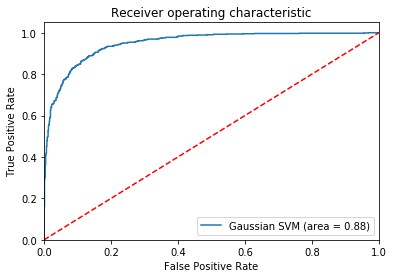

In [36]:
svm_estimator = grid_search_svm.best_estimator_
roc = plot_roc_curve(svm_estimator, features_test, labels_test, title="Gaussian SVM")
roc.show()

##### Learning curve for the Gaussian SVM
The graph shows that we have a problem with **overfitting**(high variance). Perhaps adding more training samples will most likely increase generalization and the variance will be reduced.

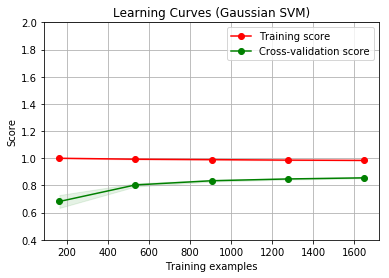

In [37]:
# Time: ~1 min
title = "Learning Curves (Gaussian SVM)"
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)

plot_learning_curve(grid_search_svm.best_estimator_, title, features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)
# print(plt.rcParams["figure.figsize"])
# plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

##### Confusion matrix for the Gaussian SVM
In this model, there is also a tendency for a larger number of **false negative(FN)** examples but mistakes are fewer.

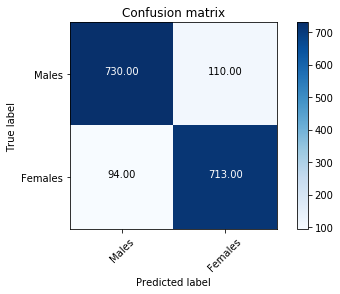

In [38]:
cnf_matrix = confusion_matrix(labels_test, grid_search_svm.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

### Random Forest Clasifier

#### Basic Random Forest

In [39]:
np.random.seed(123456)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

In [40]:
forest_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components=150)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', RandomForestClassifier(criterion='gini'))])

forest_pipeline.fit(features_train, labels_train)

print("Test score: {}".format(forest_pipeline.score(features_test, labels_test))) # 0.7698846387370978
print("Train score: {}".format(forest_pipeline.score(features_train, labels_train))) # 0.8197916666666667

Test score: 0.6727383120825744
Train score: 0.9877604166666667


#### Tune Random Forest parameters

In [41]:
# Time: ~1 min
kfold = StratifiedKFold(n_splits=3)
forest_params = dict(clf__n_estimators = [1500, 2000], clf__max_depth=[2, 3])

grid_search_forest = GridSearchCV(
    forest_pipeline, param_grid=forest_params, cv=kfold, return_train_score=True, n_jobs=6)

start = time.time()
grid_search_forest.fit(features_train, labels_train)
end = time.time()

In [42]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_forest.cv_results_['params'])))

GridSearchCV took {65.14} seconds for 4 candidate parameter settings.


In [43]:
grid_search_forest.best_params_ # {'clf__max_depth': 3, 'clf__n_estimators': 1500}

{'clf__max_depth': 3, 'clf__n_estimators': 1500}

In [44]:
print("Test score: {}".format(grid_search_forest.best_estimator_.score(features_test, labels_test))) # 0.7741347905282332
print("Train score: {}".format(grid_search_forest.best_estimator_.score(features_train, labels_train))) # 0.81953125
print("Classification Report")
print(classification_report(labels_test, grid_search_forest.predict(features_test)))

Test score: 0.7704918032786885
Train score: 0.8111979166666666
Classification Report
             precision    recall  f1-score   support

        0.0       0.80      0.73      0.76       840
        1.0       0.74      0.82      0.78       807

avg / total       0.77      0.77      0.77      1647



In [45]:
print_grid_search_results(grid_search_forest, splits=3)

,mean_test,mean_train,param_clf__max_depth,n_estimators,rank_test,split0_test,split0_train,split1_test,split1_train,split2_test,split2_train,std_test_score,std_train_score
2,0.770052,0.842450,3,1500,1,0.768931,0.852677,0.794531,0.841406,0.746677,0.833268,0.019549,0.007958
3,0.769271,0.845314,3,2000,2,0.771272,0.848378,0.789844,0.848828,0.746677,0.838735,0.017676,0.004656
0,0.755469,0.803127,2,1500,3,0.750976,0.808128,0.782813,0.811719,0.732604,0.789535,0.020739,0.009722
1,0.755469,0.802085,2,2000,3,0.749415,0.802267,0.782031,0.813281,0.734949,0.790707,0.019689,0.009217


#### Analyse the Random Forest results

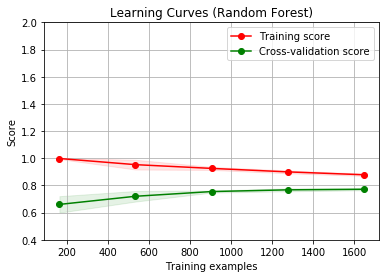

In [46]:
# Time: ~1.5 min
# prints learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)
plot_learning_curve(grid_search_forest.best_estimator_, 
                    "Learning Curves (Random Forest)", 
                    features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=6)
plt.show()

It looks like the variance can be reduced with more hyperparameters tuning or with adding more examples but the result will still be ~0.80 because the model suffers a bit of **high bias**.

##### Confusion matrix  and ROC curve for Random Forest
The matrix does not look very good in terms of the **false negative(FN)** predictions.  
The ROC curve also does not look very good - the "elbow" is very smooth.  
**The conclusion is that this is a weak model.**

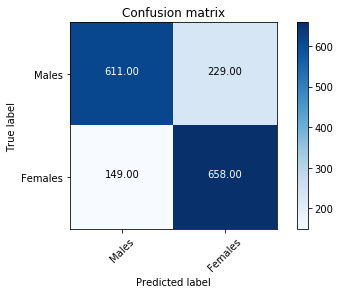

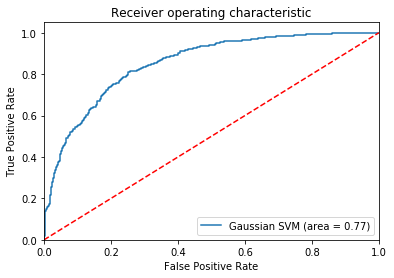

In [47]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(labels_test, grid_search_forest.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

# prints ROC curve
forest_estimator = grid_search_forest.best_estimator_
roc = plot_roc_curve(forest_estimator, features_test, labels_test, title="Gaussian SVM")
roc.show()

### Adaptive Boost

#### Basic AdaBoost with Decision Tree

In [48]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345) # , random_state=12345

tree = DecisionTreeClassifier(max_depth=1)

ada_boost_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components=150)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', AdaBoostClassifier(tree))])

ada_boost_pipeline.fit(features_train, labels_train)
print("Test score: {}".format(ada_boost_pipeline.score(features_test, labels_test))) # 0.7644201578627808
print("Train score: {}".format(ada_boost_pipeline.score(features_train, labels_train))) # 8169270833333333

Test score: 0.7680631451123254
Train score: 0.8252604166666667


#### Tune the AdaBoost parameters
Тhis is a very time consuming operation.

In [49]:
# Time: ~1.5 min
start = time.time()
params = dict(clf__n_estimators=[100, 150], clf__learning_rate=[0.1, 0.35, 0.5]) # add 50
kfold = StratifiedKFold(n_splits=5)

ada_boost_grid_search = GridSearchCV(
    ada_boost_pipeline, param_grid=params, cv=kfold, return_train_score=True, n_jobs=6)
ada_boost_grid_search.fit(features_train, labels_train)

end = time.time()
print("Time: {}".format(end - start))
ada_boost_grid_search

Time: 90.78856945037842


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('scaler_1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassi...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'clf__n_estimators': [100, 150], 'clf__learning_rate': [0.1, 0.35, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [50]:
print("Best params: {}".format(ada_boost_grid_search.best_params_))
print("Mean test score: {}".format(ada_boost_grid_search.best_estimator_.score(features_test, labels_test))) 
# 0.8032786885245902
print("Mean train score: {}".format(ada_boost_grid_search.best_estimator_.score(features_train, labels_train))) 
# 0.88203125
print_grid_search_results(ada_boost_grid_search, splits=5)
# Best params: {'learning_rate': 0.35, 'n_estimators': 150}
print("Classification Report")
print(classification_report(labels_test, ada_boost_grid_search.predict(features_test)))

# Confusion matrix
cnf_matrix = confusion_matrix(labels_test, ada_boost_grid_search.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

Best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 150}
Mean test score: 0.8081360048573163
Mean train score: 0.8716145833333333
Classification Report
             precision    recall  f1-score   support

        0.0       0.82      0.80      0.81       840
        1.0       0.79      0.82      0.81       807

avg / total       0.81      0.81      0.81      1647



#### Analyse the Ada Boost results
The result is slightly better than Random Forest model but is still relatively weak.

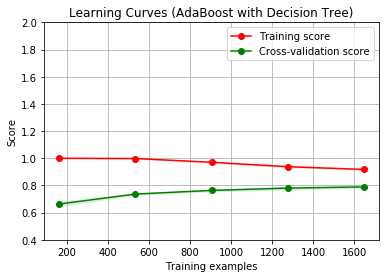

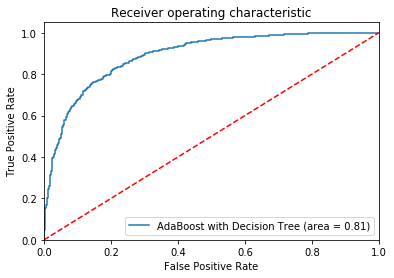

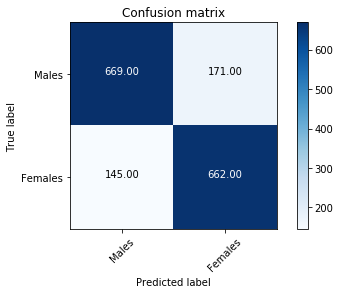

In [51]:
# Time: ~2 min
ada_boost_estimator = ada_boost_grid_search.best_estimator_
# prints learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)
plot_learning_curve(ada_boost_estimator, 
                    "Learning Curves (AdaBoost with Decision Tree)", 
                    features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=6)
plt.show()

# prints ROC curve
roc = plot_roc_curve(ada_boost_estimator, features_test, labels_test, title="AdaBoost with Decision Tree")
roc.show()

# Plot confusion matrix
cnf_matrix = confusion_matrix(labels_test, ada_boost_estimator.predict(features_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

### Experimental: attempt to combine models

Now I'll try to combine models to get a better result. My idea is the following:

We have $k$ different hypothesis(for example Logistic Regression, SVM and Decision Tree). Then $h_k(X)=y$, where $k>1$, $X$ is the feature matrix, $y$ is the labels vector. Then we can construct a new dataset and hypothesis that will look like this:

$
H \Bigg(
\begin{bmatrix}
    h_{1}(X_{1\bullet}) & h_{2}(X_{1\bullet}) & \dots  & h_{k}(X_{1\bullet}) \\
    h_{2}(X_{2\bullet}) & h_{2}(X_{2\bullet}) & \dots  & h_{2}(X_{2\bullet}) \\
    \vdots & \vdots & \ddots & \vdots \\
    h_{1}(X_{n\bullet}) & h_{2}(X_{n\bullet}) & \dots & h_{k}(X_{n\bullet})
\end{bmatrix}
\Bigg) = y
$, where $H$ is a new hypothesis, $X_{i\bullet}$ represents the $i$-th row of the matrix $X$.

For $h_1, h_2, ...,h_k$ I'll chose hypothesis with different nature. For example I can chose $h_{k}\{k=1,2\}$ where $h_1$ is a logistic regression and $h_2$ is a random forest. These are two completely different species. My intuition suggests that this should be the case - to choose completely different algorithms. It makes no sense, for example, to get two types of logistic regresion or random forest and decision tree, because they are very similar. Later I can make more features with polynomial features. For $H$ I can try a simple hypothesis like logistic regression.

Now I will generate new features from **Logistic regression model** and **AdaBoost Model**.

In [52]:
# Time: ~1min
new_features = np.empty(shape=(0,2))
for image in features:
    # svm = svm_result = grid_search_svm.predict_proba([image])[0][1]
    logr = grid_search_logistic_regresion.predict_proba([image])[0][1]
    adabst = ada_boost_grid_search.predict_proba([image])[0][1]
    
    new_features = np.append(new_features, [[logr, adabst]], axis=0)

In [53]:
new_data = pd.DataFrame({"Logistic Regression":new_features[:,0], "Ada Boost":new_features[:,1], "labels":labels})
new_data.head()

,Ada Boost,Logistic Regression,labels
0,0.500375,0.513908,1.0
1,0.495182,0.495535,0.0
2,0.496384,0.484281,0.0
3,0.499146,0.506890,1.0
4,0.500428,0.511645,1.0


In [55]:
new_features_train, new_features_test, labels_train, labels_test = train_test_split(
    new_features, labels, train_size=0.7, test_size=0.3, random_state=42)

pipe = Pipeline(steps=[('poly', PolynomialFeatures(degree=2, interaction_only=False)),
                       ('lr', LogisticRegression())])

pipe.fit(new_features_train, labels_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [56]:
pipe.score(new_features_test, labels_test)

0.8664238008500303

In [57]:
pipe.score(new_features_train, labels_train)

0.8583333333333333

In [58]:
grid_search_experiment = GridSearchCV(
    pipe, param_grid=dict(lr__C = [0.1, 0.5, 1, 10]), cv=StratifiedKFold(n_splits=8))
grid_search_experiment.fit(new_features_test, labels_test)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr__C': [0.1, 0.5, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [59]:
grid_search_experiment.score(new_features_test, labels_test)

0.8688524590163934

In [60]:
grid_search_experiment.score(new_features_train, labels_train)

0.8588541666666667

In [61]:
grid_search_experiment.best_params_

{'lr__C': 10}

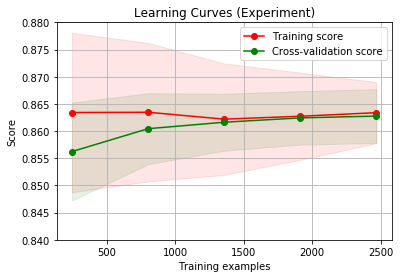

In [62]:
cv = ShuffleSplit(n_splits=10, test_size=0.55, random_state=0)
plot_learning_curve(grid_search_experiment.best_estimator_, 
                    "Learning Curves (Experiment)", 
                    new_features, labels, ylim=(0.84, 0.88), cv=cv, n_jobs=4)
plt.show()

The graph looks a bit weird. Maybe the bias is too high or the metric I chose is not appropriate. I'm probably wrong somewhere but the score seems better than the two algorithms separately. I'll include this algorithm in the demo to compare the results.

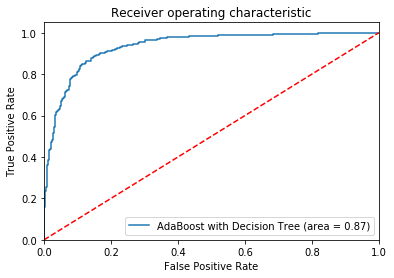

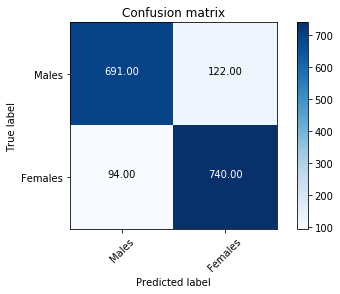

In [63]:
experiment = grid_search_experiment.best_estimator_
# prints ROC curve
roc = plot_roc_curve(experiment, new_features_test, labels_test, title="AdaBoost with Decision Tree")
roc.show()

# Plot confusion matrix
cnf_matrix = confusion_matrix(labels_test, experiment.predict(new_features_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

### Best model selection

In [64]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

# Prints the models ordered by the mean test score
logistic_regression_score = grid_search_logistic_regresion.best_estimator_.score(features_test, labels_test)
linear_svm_score = grid_search_linear_svm.best_estimator_.score(features_test, labels_test)
gaussin_svm_score = grid_search_svm.best_estimator_.score(features_test, labels_test)
random_forest_score = grid_search_forest.best_estimator_.score(features_test, labels_test)
ada_boost_score = ada_boost_grid_search.best_estimator_.score(features_test, labels_test)

res = pd.DataFrame({'Classificator': ["Logistic Regressin", "Linear SVM", "Gaussian SVM", 
                                "Random Forest", "AdaBoost with Decision tree"], 
                   'Mean test score': [logistic_regression_score, linear_svm_score, gaussin_svm_score, 
                                       random_forest_score, ada_boost_score]})

res.sort_values(by='Mean test score', inplace=True, ascending=False)
res.head()

,Classificator,Mean test score
2,Gaussian SVM,0.876138
1,Linear SVM,0.845173
0,Logistic Regressin,0.839101
4,AdaBoost with Decision tree,0.808136
3,Random Forest,0.770492


- **Logistic regression, Linear SVM, Random Forest and AdaBoost**: From the graph of Logistic Regression and Linear SVM it can be seen that it is difficult to achieve better results even if additional training samples are added. Refinement of parameters also does not work well. Тherefore the bias needs to be changed. Maybe adding of polynomial features to the Logistic Regression model may work but in this case the features are too many for polynomial regression.


- On the other hand, the **Gaussian SVM** model gives the best results and despite the variance it seems that adding more samples will decrease the variance and will increase the test accuracy.

**I choose SVM with Gaussian kernel.**

## Demo

The demo is divided into two parts:
- For the first part you need a working camera. The faces that the camera sees will be detected with `haar faces`. Press `Q` key and all faces will be cropped and transformed. The transformed information will be submitted on different models and the result will be displayed.


- The second demo is the same as the first but the information is taken from the local image and not from the camera.

If you have built the models the demo will use them, otherise it will use saved local prebuilt images. If you use the prebuilt images it is possible to have a problem with loading the AdaBoost image. But the demo will still work.

### Define helpers

In [65]:
FACE_CASCADE_PATH = './faces_data/face.xml'

def predict(image):
    """ 
    Display the result of several models 
    If a model does not exists - try to load a saved model from the local storage
    If a model exists but is not saved - save a model to a local sotrage
    If a model is already saved - use the model from the memory (do not use the saved model)
    """
    svm_model = None
    logistic_regression_model = None
    ada_boost_model = None
    
    row_image = image.ravel()
    
    names = [('grid_search_svm', './saved_models/svm_model.sav', 'Gaussian SVM model'),
             ('grid_search_logistic_regresion','./saved_models/logistic_regression_model.sav',
              'Logistic Regression model'),
             ('ada_boost_grid_search', './saved_models/ada_boost_model.sav', 'AdaBoost model')]

    res = ""
    for tuple_name in names:
        model_name = tuple_name[0]
        location = tuple_name[1]
        title = tuple_name[2]
        
        try:
            if not os.path.exists(location) and model_name in globals():
                model = (globals()[model_name]).best_estimator_
                pickle.dump(model, open(location, 'wb'))
                print("A model is dumped.")
            elif os.path.exists(location) and not model_name in globals():
                model = pickle.load(open(location, 'rb'))    
                print("Warn: '{}' model is loaded from the local storage.".format(model_name))
            elif model_name in globals():
                model = (globals()[model_name]).best_estimator_
                print("{} model is used from the memory.".format(model_name))
            else:
                print("Error: Can't find a model. Please build {} model first.".format(model_name))
            res += get_result(model.predict_proba([row_image]), title) + "\n\n"
        except Exception as ex:
            print(ex)
    
    if 'grid_search_experiment' in globals():
        lr = grid_search_logistic_regresion.predict_proba([row_image])[0][1]
        ada = ada_boost_grid_search.predict_proba([row_image])[0][1]

        experiment = grid_search_experiment.predict_proba([[lr, ada]])
        res += get_result(experiment, "Experiment") + "\n\n"
         
    plt.figure()
    plt.imshow(image.reshape(40,40), cmap=plt.cm.bone)
    plt.annotate(res,xy=(0,0), xytext=(45,40), fontsize=20)    

    
def get_result(result_proba, title):
    """ Returns a result with model title """
    if result_proba[0][1] > .5:
        res = "Man({:.2f}%)".format(result_proba[0][1]*100.)
    else:
        res ="Woman({:.2f}%)".format(result_proba[0][0]*100.)
        
    return "{}: {}".format(title, res)

### Gender recognition from the camera
Start and pres `Q` key to start gender recognition process.

grid_search_svm model is used from the memory.
grid_search_logistic_regresion model is used from the memory.
ada_boost_grid_search model is used from the memory.


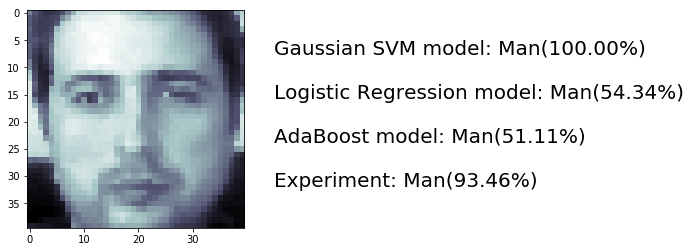

In [71]:
def recognize_faces_from_frame():
    # data:       https://github.com/opencv/opencv/tree/master/data/haarcascades
    # faces, see: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    my_image = None

    cap = cv2.VideoCapture(0)
    is_running = True
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # looks for faces within the image
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        w = 0 #30
        h = 0 #50
        for (x, y, width, height) in faces:
            # draws a rectangle around the detected face
            cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
            face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]

            if cv2.waitKey(1) == ord('q') or not is_running:
                resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
                try:
                    predict(resized)
                except Exception as ex:
                    print("Error: {}".format(ex))           
                is_running = False

        cv2.imshow('frame', frame)

        if not is_running:
            break

    cap.release()
    cv2.destroyAllWindows()

recognize_faces_from_frame()

### Gender recognition from an image
You can change the indexes(`demo_faces_0.jpg, demo_faces_1.jpg, ..., demo_faces_6.jpg`) to test the model with various sets of faces.

grid_search_svm model is used from the memory.
grid_search_logistic_regresion model is used from the memory.
ada_boost_grid_search model is used from the memory.
grid_search_svm model is used from the memory.
grid_search_logistic_regresion model is used from the memory.
ada_boost_grid_search model is used from the memory.
grid_search_svm model is used from the memory.
grid_search_logistic_regresion model is used from the memory.
ada_boost_grid_search model is used from the memory.
grid_search_svm model is used from the memory.
grid_search_logistic_regresion model is used from the memory.
ada_boost_grid_search model is used from the memory.
grid_search_svm model is used from the memory.
grid_search_logistic_regresion model is used from the memory.
ada_boost_grid_search model is used from the memory.
grid_search_svm model is used from the memory.
grid_search_logistic_regresion model is used from the memory.
ada_boost_grid_search model is used from the memory.
grid_search_svm model is use

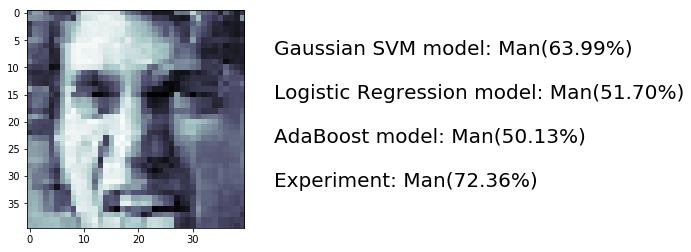

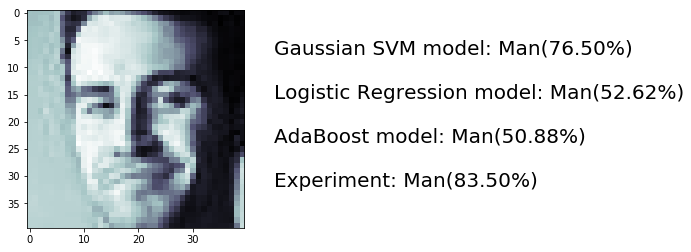

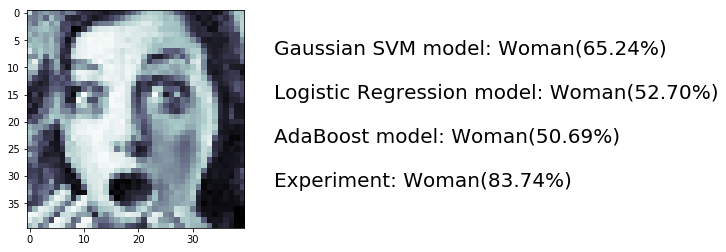

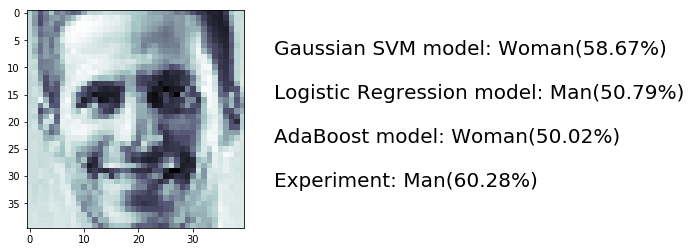

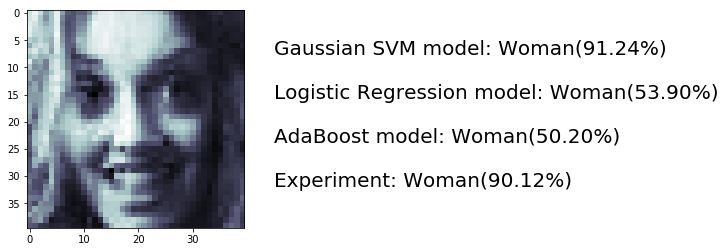

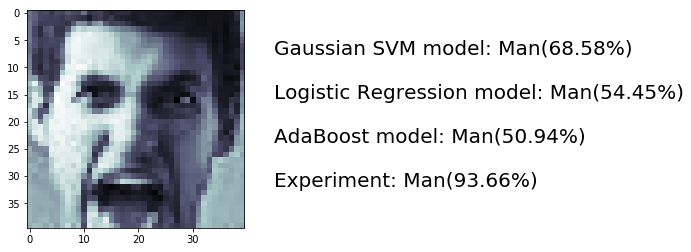

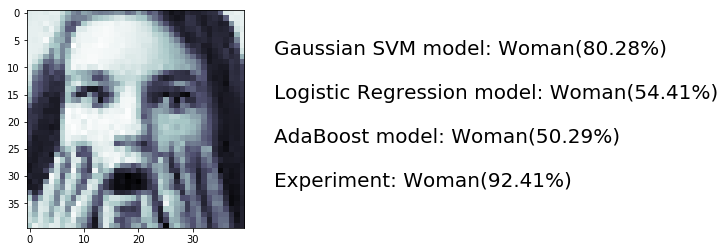

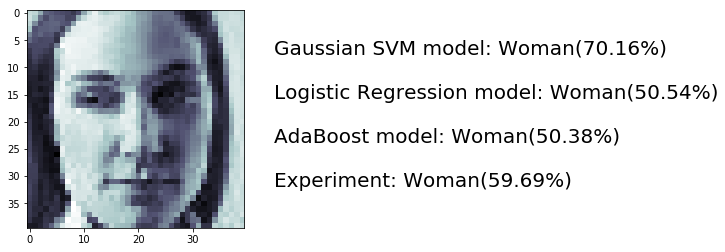

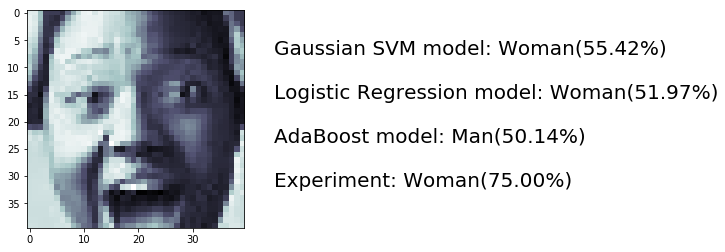

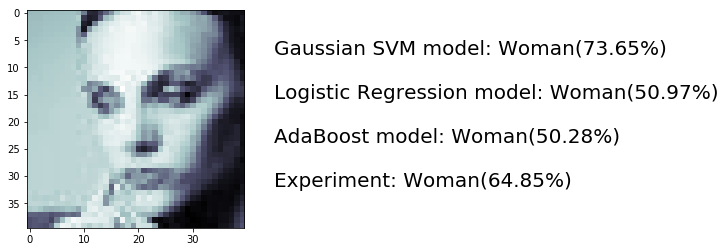

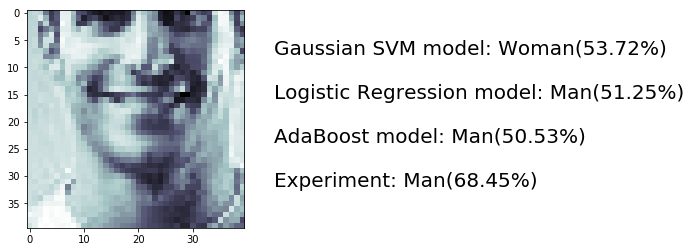

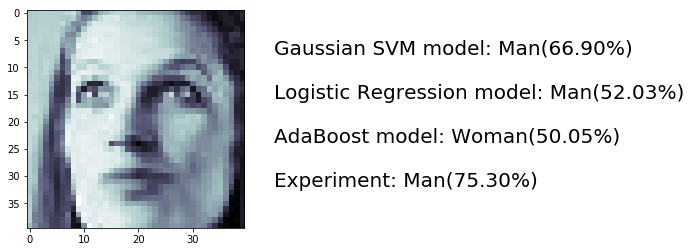

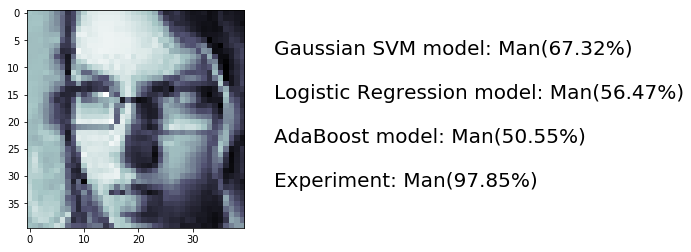

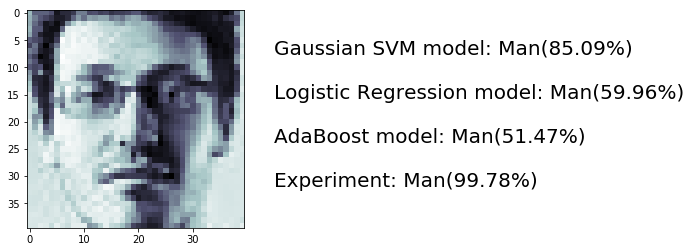

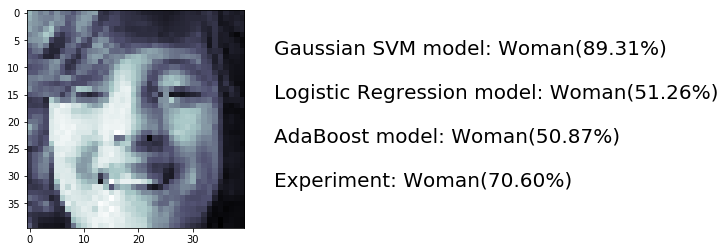

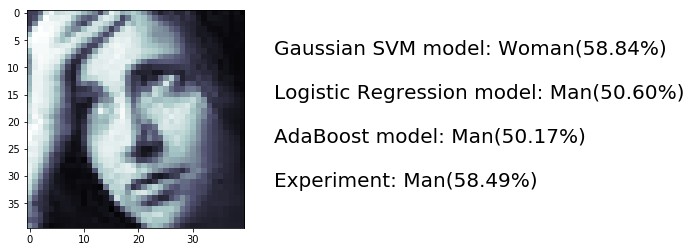

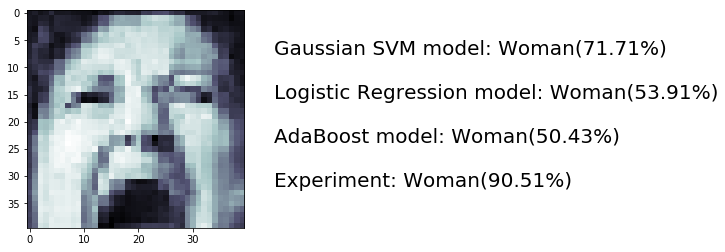

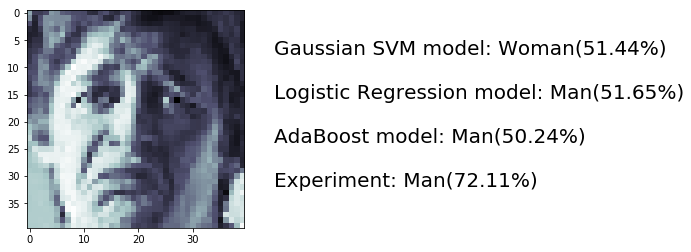

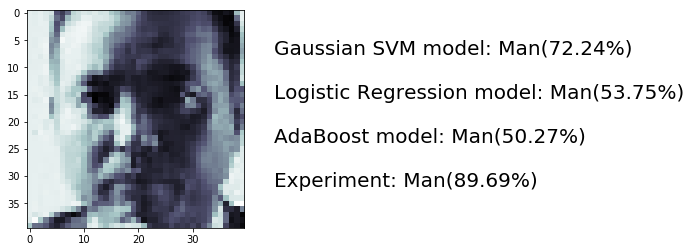

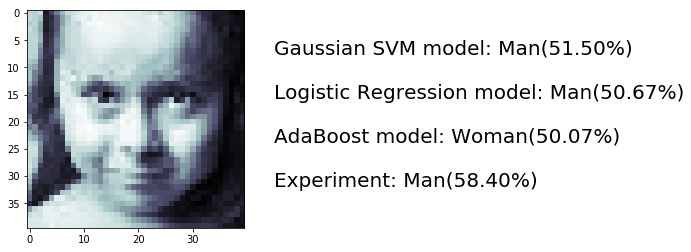

In [72]:
def recognize_faces_from_image(image):
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    w = 0
    h = 0
    for (x, y, width, height) in faces:
        #cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
        face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        try:
            predict(resized)
        except Exception as ex:
            print("Error: {}".format(ex))

recognize_faces_from_image(cv2.imread('./faces_data/demo_data/demo_faces_1.jpg'))